# Diversion Analysis & Piecewise Linear Fit Modeling
This script performs a detailed analysis of river diversions, unregulated inflows
and reservoir storage to determine the best piecewise linear fit for each reach.

## Key steps and operations:
Data Importing: Imports historical and modeled diversions, unregulated
inflows from the South Fork and Henry's Fork, and reservoir storage data.

## Data Processing: For each year, computes the cumulative sum of inflows
and subtracts it from the total sum. It then adds the reservoir storage.

## Flow Calculation: For each reach and month, calculates the gap between
historical and modeled diversions.

## Piecewise Linear Fit: Computes a piecewise linear fit of the river
diversion as a function of water supply. It calculates separate slopes
before and after the breakpoint.

## Data Export: Saves the slopes and break values for each reach and month
into CSV files.

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import os

This is the piecewise function we are trying to fit to the water supply and diversion data. It is a linear function with a breakpoint.

In [3]:
def piecewise_linear(x, m, b, y2):
    return np.piecewise(x, [x < b, x >= b], [lambda x: m * (x - b) + y2, y2])

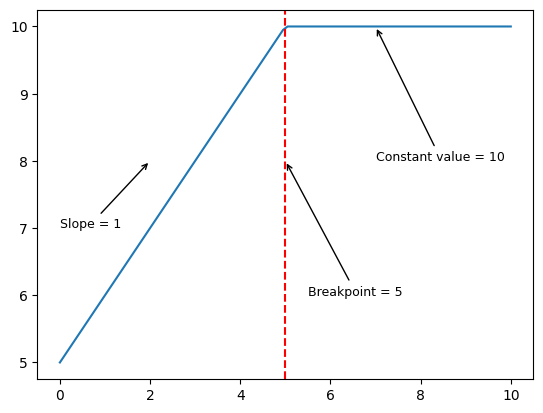

In [15]:
# Example of the piecewise linear function
x = np.linspace(0, 10, 100)
y = piecewise_linear(x, 1, 5, 10)

fig, ax = plt.subplots()
ax.plot(x, y)

ax.annotate('Slope = {}'.format(1), xy=(2, 8), xytext=(0, 7),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=9)

ax.axvline(x=5, color='r', linestyle='--')
ax.annotate('Breakpoint = {}'.format(5), xy=(5, 8), xytext=(5.5, 6),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=9)

ax.annotate('Constant value = {}'.format(10), xy=(7, 10), xytext=(7, 8),
            arrowprops=dict(facecolor='black', arrowstyle="->"),
            fontsize=9)

plt.show()

In this example, we are going to specifically look at how diversions on Reach 4 of the Snake River are calculated. This reach includes Farmer's Friend, Enterprize, Harrison, Burgess, and others along the South Fork.

In [13]:
BasinName = "SNK"
reach = "Reach4Diversions_SNK"

Here we import and plot the historical diversions and modeled full water supply diversions for Reach 4 calculated in the previous notebook. 

As we can see below, the modeled full water supply diversions match fairly closely from 1995-2000, which was a period with a large water supply. However, starting in 2001 the observed water supply is lower than the modeled water supply due to a lack of water available for diversions. In the rest of the notebook, we are looking to find the relationship between the water supply and the diversions.

Text(0.5, 0.98, 'Observed and Modeled Diversions')

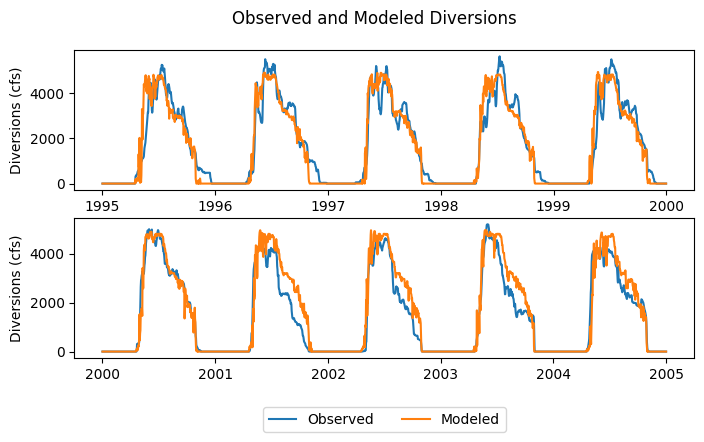

In [26]:
HistoricalDiversions = pd.read_csv(f"../Outputs/{BasinName}/ObservedDiversions.csv",
                                    index_col=0, parse_dates=True).dropna()
ModeledDiversions = pd.read_csv(f"../Outputs/{BasinName}/ReachDiversions.csv", 
                                index_col=0, parse_dates=True).dropna()


fig, axes = plt.subplots(2, 1, figsize=(8, 4))

# Plot 1996-2000
axes[0].plot(HistoricalDiversions.loc[(HistoricalDiversions.index >= "1995-01-01") & (HistoricalDiversions.index < "2000-01-01"), reach],
        label="Observed")
axes[0].plot(ModeledDiversions.loc[(ModeledDiversions.index >= "1995-01-01") & (ModeledDiversions.index < "2000-01-01"), reach],
        label="Modeled")
axes[0].set_ylabel("Diversions (cfs)")


# Plot 2000-2005
axes[1].plot(HistoricalDiversions.loc[(HistoricalDiversions.index >= "2000-01-01") & (HistoricalDiversions.index < "2005-01-01"), reach],
        label="Observed")
axes[1].plot(ModeledDiversions.loc[(ModeledDiversions.index >= "2000-01-01") & (ModeledDiversions.index < "2005-01-01"), reach],
        label="Modeled")
axes[1].set_ylabel("Diversions (cfs)")


# Plot the legend on the bottom
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.suptitle("Observed and Modeled Diversions")

This reach is along the South Fork of the Snake River. The available water supply for diversions here is the sum of reservoir contents in Jackson and Palisades Reservoirs, and the unregulated inflows from the South Fork.

In [38]:
WaterSupplySources = {'Inflow': ['HEII'], 'Reservoirs': ['jck_af', 'pal_af']}

We must pick which day of the year to start our analysis. In this case, we are using April 1st, which is the start of the irrigation season. This may need to be adjusted for other basins if the irrigation season starts at a different time.

In [17]:
StartDay = 91

From the USBR website, we can find the historical reservoir contents for Jackson Lake and Palisades Reservoir. We can also find the unregulated inflows from the South Fork of the Snake River. We will use these to calculate the available water supply for diversions.

To calculate the available water supply for diversions during the irrigation season, we will calculate the sum of natural flow available on the South Fork from April 1st to September 30th, and the sum of reservoir contents in Jackson Lake and Palisades Reservoir on April 1st. We will then add these two values together to get the total water supply available for diversions.

Text(0.5, 1.0, 'Total available water supply (AF)')

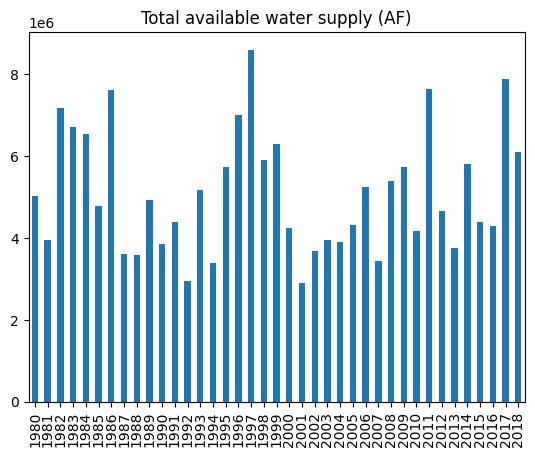

In [39]:
WaterSupply = pd.Series(index=pd.date_range('1980-01-01', '2018-12-31', freq='D')).fillna(0)


for flow in WaterSupplySources['Inflow']:
    df = pd.read_html(f"https://www.usbr.gov/pn-bin/daily.pl?station={flow}&format=html&year=1980&month=1&day=1&year=2018&month=12&day=31&pcode=qu", 
                                    index_col=0, parse_dates=True)[0]
    df *= 1.9835
    df.loc[(df.index.dayofyear < StartDay) & (df.index.dayofyear > 273)] = 0
    WaterSupply += df.values.flatten()

for reservoir in WaterSupplySources['Reservoirs']:
    df = pd.read_html(f"https://www.usbr.gov/pn-bin/daily.pl?station={reservoir}&format=html&year=1980&month=1&day=1&year=2018&month=12&day=31&pcode=af", 
                                    index_col=0, parse_dates=True)[0]
    df.loc[df.index.dayofyear!=StartDay] = 0
    WaterSupply += df.values.flatten()

WaterSupply = WaterSupply.resample("1Y").sum()

WaterSupply.plot.bar()
# set the x-axis tick labels to the years only
plt.xticks([i for i in range(0, len(WaterSupply.index))], [i.year for i in WaterSupply.index])
plt.title("Total available water supply (AF)")

Calculate the difference between the modeled full water supply diversions and the historical diversions. This is the gap we are trying to fit with the piecewise linear fit.We only look at years after 2000 due to irrigation practices changing in the 1990s. 

In general, we see a linear relationship between the water supply and the diversion gap. However, there is a breakpoint around 4.5 million acre-feet where the slope of the relationship changes and flattens out. We will use a piecewise linear fit to model this relationship.

Text(0, 0.5, 'Average Diversion Gap (CFS)')

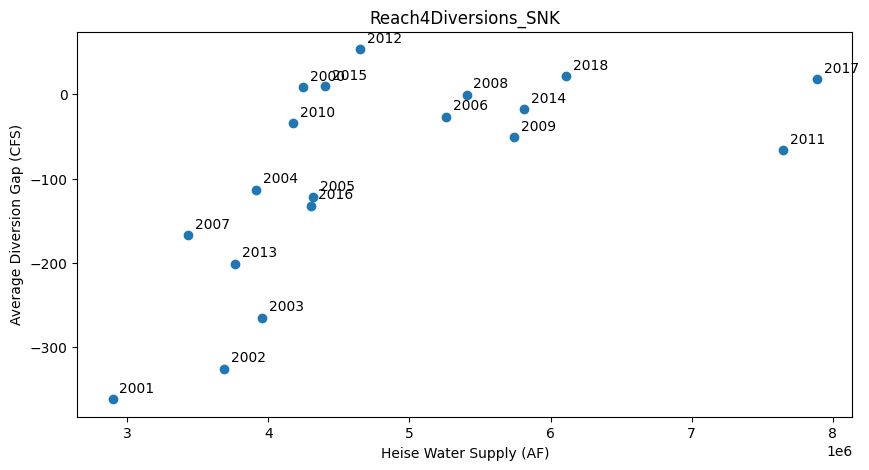

In [53]:
# Get the gap between the historical diversions and the previously calculated full water supply diversions
Flow = (HistoricalDiversions - ModeledDiversions.reindex(HistoricalDiversions.index))[reach]

# Calculate the cumulative sum of the gap for July and August
Flow = Flow.resample("1Y").mean().fillna(0)
Flow = Flow.loc[Flow.index.year >= 2000]

# Plot the flow vs the WaterSupply
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(WaterSupply, Flow, label="Historical Diversions")

# add labels for each year
for i, txt in enumerate(Flow.index.year):
    ax.annotate(
        txt,
        (WaterSupply.values[i], Flow.values[i]),
        xytext=(5, 5),
        textcoords="offset points",
    )

plt.title(f"{reach}")
plt.xlabel(f"Heise Water Supply (AF)")
plt.ylabel("Average Diversion Gap (CFS)")

Here is where we calculate the relationship between the water supply and the diversions. We exclude the 5th smallest and 5th largest water supply values to avoid outliers. We then fit a piecewise linear function to the data.

In [56]:
WaterSupply = WaterSupply.reindex(Flow.index)

# Set the bounds for the piecewise linear fit to be the 5th smallest and 5th largest water supply values
bounds = [
    [WaterSupply.nsmallest(5).iloc[4], WaterSupply.nlargest(5).iloc[4]],
    [0, 1],
]


# Fit the piecewise linear function
p, e = curve_fit(
    piecewise_linear,
    WaterSupply.values,
    Flow.values,
    p0=[0.01, WaterSupply.mean(), 0],
)


m = p[0]
b = p[1]
y2 = p[2]

print(f"Slope = {m:.2E} cfs/AF")
print(f"Breakpoint = {b:.2E} AF")
print(f"Offset = {y2:.2f} cfs")

Slope = 2.15E-04 cfs/AF
Breakpoint = 4.60E+06 AF
Offset = -8.53 cfs


Text(0, 0.5, 'Average Diversion Gap (CFS)')

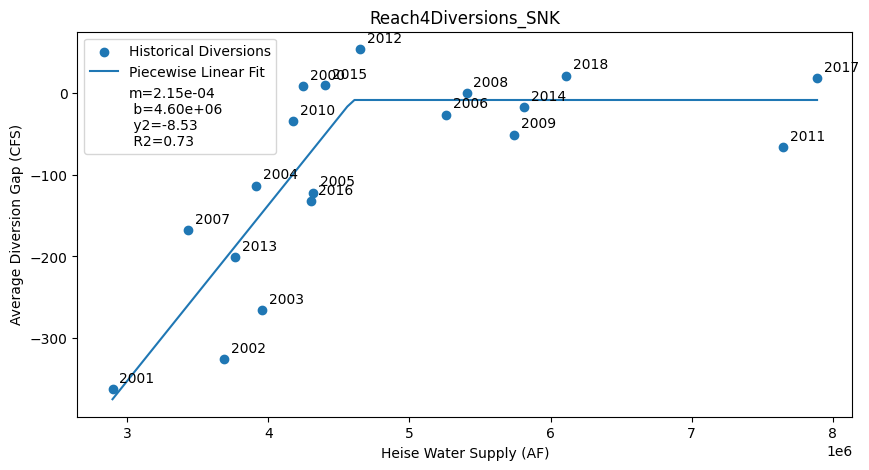

In [52]:
# Plot the flow vs the WaterSupply
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(WaterSupply, Flow, label="Historical Diversions")

# add labels for each year
for i, txt in enumerate(Flow.index.year):
    ax.annotate(
        txt,
        (WaterSupply.values[i], Flow.values[i]),
        xytext=(5, 5),
        textcoords="offset points",
    )


# Plot the piecewise linear fit
xHat = np.linspace(WaterSupply.min(), WaterSupply.max(), 100)
yHat = piecewise_linear(xHat, m, b, y2)
ax.plot(xHat, yHat, label="Piecewise Linear Fit")

# Calculate the R2 value
r2 = r2_score(Flow, piecewise_linear(WaterSupply.values, m, b, y2))

# Add the legend and title
params = f"m={m:.2e}\n b={b:.2e}\n y2={y2:.2f}\n R2={r2:.2f}"
plt.plot([], [], " ", label=params)

plt.legend()
plt.title(f"{reach}")
plt.xlabel(f"Heise Water Supply (AF)")
plt.ylabel("Average Diversion Gap (CFS)")

Lastly, we need to calculate the 

<Axes: xlabel='DATE'>

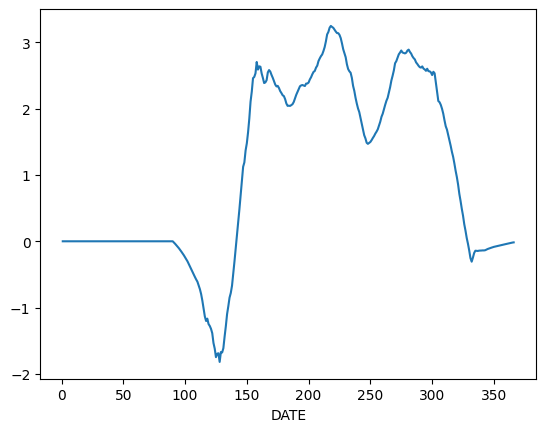

In [57]:

ReachGap = pd.Series(index=range(366))

gap = (
    HistoricalDiversions - ModeledDiversions.reindex(HistoricalDiversions.index)
).loc[
    (HistoricalDiversions.index.year > 2000)
    * (HistoricalDiversions.index.year < 2020),
    reach,
]
gap = gap.groupby(gap.index.dayofyear).mean()
gap.loc[gap.index < StartDay] = 0

# Set the mean to 1

gap = gap.rolling(30).mean().fillna(0)

ReachGap = gap


# Set each column to have a mean of 1
ReachGap = ReachGap / ReachGap.mean()

ReachGap.plot()